In [6]:
!pip install transformers datasets seqeval scikit-learn
!pip install --upgrade transformers

import requests
import re
from io import StringIO
import pandas as pd
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, AutoTokenizer, pipeline
from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=41f58b49e91207567cc80b8719dd416b656e6a7990f9c69e6748162c1abccf2c
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [7]:
# Baixar dados
url = "https://raw.githubusercontent.com/davidsbatista/NER-datasets/refs/heads/master/Portuguese/leNER-Br/dev.conll"
response = requests.get(url)
raw_text = response.text

# Parse
sentences = []
ner_tags = []
tokens = []
tags = []

for line in raw_text.splitlines():
    line = line.strip()
    if line == "":
        if tokens:
            sentences.append(tokens)
            ner_tags.append(tags)
            tokens, tags = [], []
    else:
        parts = re.split(r"\s+", line)
        if len(parts) == 2:
            token, tag = parts
            tokens.append(token)
            tags.append(tag)

if tokens:
    sentences.append(tokens)
    ner_tags.append(tags)

examples = [{"tokens": s, "ner_tags": t} for s, t in zip(sentences, ner_tags)]

print(f"Total de sentenças: {len(examples)}")
print("Exemplo:", examples[0])


Total de sentenças: 1176
Exemplo: {'tokens': ['E', 'M', 'E', 'N', 'T', 'A', 'Órgão', ':', '8ª', 'TURMA', 'CÍVEL', 'Classe', ':', 'APELAÇÃO', 'CÍVEL', 'N', '.', 'Processo', ':', '20150110436469APC', '(', '0012843-03.2015.8.07.0001', ')', 'Apelante', '(', 's', ')', ':', 'BRASILIA', 'CURSOS', 'E', 'CONCURSOS', 'LTDA', 'GRANCURSOS', 'ESCOLA', 'PARA', 'CONCURSOS', 'PUBLICOS', 'LTDA', 'Apelado', '(', 's', ')', ':', 'ALISSON', 'SILVA', 'BATISTA', 'DE', 'MORAES', 'Relatora', ':', 'Desembargadora', 'NÍDIA', 'CORRÊA', 'LIMA', 'Acórdão', 'N.', ':', '1082726', 'CIVIL', 'E', 'PROCESSUAL', 'CIVIL', '.'], 'ner_tags': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZACAO', 'I-ORGANIZACAO', 'I-ORGANIZACAO', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-JURISPRUDENCIA', 'O', 'B-JURISPRUDENCIA', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZACAO', 'I-ORGANIZACAO', 'I-ORGANIZACAO', 'I-ORGANIZACAO', 'I-ORGANIZACAO', 'I-ORGANIZACAO', 'I-ORGANIZACAO', 'I-ORGANIZACAO', 'I-ORGANIZACAO', 'I-ORGANIZACAO', 'O', 'O', 'O'

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

train_data, test_data = train_test_split(examples, test_size=0.2, random_state=42)

dataset = DatasetDict({
    "train": Dataset.from_list(train_data),
    "test": Dataset.from_list(test_data),
})


In [ ]:
model_checkpoint = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")

# Mapear rótulos
label_list = sorted(list({tag for ex in examples for tag in ex["ner_tags"]}))
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

# Função de tokenização
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(
        example["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",  # <- importante!
        max_length=128,        # <- para uniformizar o tamanho
    )

    word_ids = tokenized_inputs.word_ids()
    label_ids = []
    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            label_ids.append(-100)
        elif word_idx != previous_word_idx:
            label_ids.append(label2id[example["ner_tags"][word_idx]])
        else:
            label_ids.append(-100)  # sub-palavras são ignoradas
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = label_ids
    return tokenized_inputs

# Tokenizar dataset
tokenized_dataset = dataset.map(tokenize_and_align_labels)
print("Entidades reconhecidas:", label_list)

Map:   0%|          | 0/940 [00:00<?, ? examples/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Entidades reconhecidas: ['B-JURISPRUDENCIA', 'B-LEGISLACAO', 'B-LOCAL', 'B-ORGANIZACAO', 'B-PESSOA', 'B-TEMPO', 'I-JURISPRUDENCIA', 'I-LEGISLACAO', 'I-LOCAL', 'I-ORGANIZACAO', 'I-PESSOA', 'I-TEMPO', 'O']


In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="./ner-bert-learnbr",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
)

# Métricas
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_preds = [
        [id2label[p] for (p, l) in zip(pred, lab) if l != -100]
        for pred, lab in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(pred, lab) if l != -100]
        for pred, lab in zip(predictions, labels)
    ]
    return {
        "precision": precision_score(true_labels, true_preds),
        "recall": recall_score(true_labels, true_preds),
        "f1": f1_score(true_labels, true_preds),
        "accuracy": accuracy_score(true_labels, true_preds),
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-19-1625969013.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jeanpinhata (jeanpinhata-faculdade-de-tecnologia-de-ourinhos) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.231882,0.548589,0.546875,0.547731,0.927852
2,No log,0.095587,0.772455,0.806250,0.788991,0.975610
3,No log,0.072448,0.804469,0.900000,0.849558,0.982766
4,No log,0.076131,0.856716,0.896875,0.876336,0.982328
5,No log,0.074233,0.881098,0.903125,0.891975,0.983935
6,No log,0.064595,0.868657,0.909375,0.888550,0.985103
7,No log,0.066909,0.876506,0.909375,0.892638,0.983935
8,No log,0.063214,0.870871,0.906250,0.888208,0.985249
9,0.122100,0.064561,0.892966,0.912500,0.902628,0.985979
10,0.122100,0.064977,0.881818,0.909375,0.895385,0.985395


TrainOutput(global_step=590, training_loss=0.1052657341552993, metrics={'train_runtime': 12996.6828, 'train_samples_per_second': 0.723, 'train_steps_per_second': 0.045, 'total_flos': 614108445542400.0, 'train_loss': 0.1052657341552993, 'epoch': 10.0})

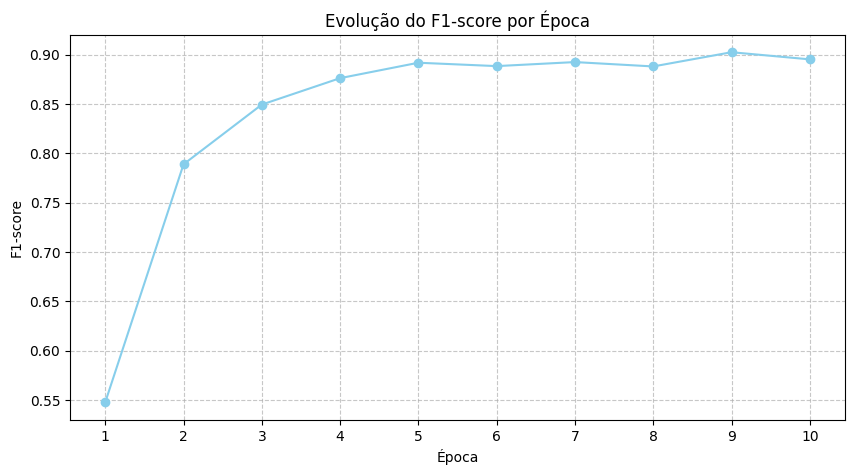

In [ ]:
epochs = list(range(1, 11))
f1_scores = [
    0.547731,
    0.788991,
    0.849558,
    0.876336,
    0.891975,
    0.888550,
    0.892638,
    0.888208,
    0.902628,
    0.895385
]

plt.figure(figsize=(10, 5))
plt.plot(epochs, f1_scores, marker='o', linestyle='-', color='skyblue')
plt.title("Evolução do F1-score por Época")
plt.xlabel("Época")
plt.ylabel("F1-score")
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


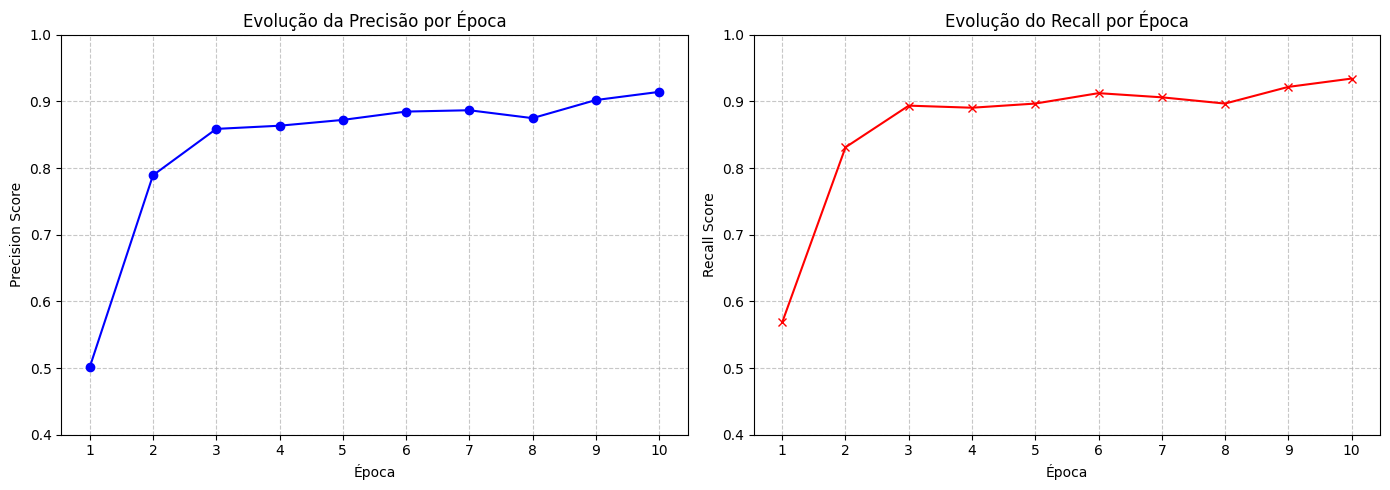

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))

precision = [
    0.501377,
    0.789318,
    0.858859,
    0.863636,
    0.872340,
    0.884848,
    0.886850,
    0.875000,
    0.902141,
    0.914373
]

recall = [
    0.568750,
    0.831250,
    0.893750,
    0.890625,
    0.896875,
    0.912500,
    0.906250,
    0.896875,
    0.921875,
    0.934375
]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.plot(epochs, precision, marker='o', linestyle='-', color='blue')
ax1.set_title("Evolução da Precisão por Época")
ax1.set_xlabel("Época")
ax1.set_ylabel("Precision Score")
ax1.set_ylim(0.4, 1.0)
ax1.set_xticks(epochs)
ax1.grid(True, linestyle='--', alpha=0.7)

ax2 = axes[1]
ax2.plot(epochs, recall, marker='x', linestyle='-', color='red')
ax2.set_title("Evolução do Recall por Época")
ax2.set_xlabel("Época")
ax2.set_ylabel("Recall Score")
ax2.set_ylim(0.4, 1.0)
ax2.set_xticks(epochs)
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
trainer.save_model("bert-lenerbr-final-f1-0_92")


In [ ]:
model_path = "/content/bert-lenerbr-final-f1-0_92"

if not os.path.exists(model_path):
    print(f"Erro: O diretório do modelo '{model_path}' não foi encontrado.")
    print("Por favor, verifique o caminho e certifique-se de que o modelo foi salvo corretamente.")
else:
    print(f"Carregando modelo do caminho: {model_path}")
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        ner_pipeline = pipeline(
            "ner",
            model=model_path,
            tokenizer=tokenizer,
            aggregation_strategy="simple"
        )
        print("Modelo e pipeline carregados com sucesso!")

        text = "Em 18 de julho de 2023, a advogada Ana Paula Resende da Ordem dos Advogados do Brasil, localizada em Curitiba, argumentou com base no Artigo 14 da Constituição Federal e citou o Recurso Especial 123.456/SP, reforçando seu ponto."

        try:
            entities = ner_pipeline(text)

            if entities:
                print("\nEntidades Extraídas:")
                for entity in entities:
                    print(f"'{entity['word']}' -> Tipo: {entity['entity_group']}")
            else:
                print("Nenhuma entidade foi encontrada nesta frase.")
        except Exception as e:
            print(f"Ocorreu um erro ao processar a frase: {e}")
            print("Por favor, tente novamente ou verifique se o modelo foi carregado corretamente.")

    except Exception as e:
        print(f"Erro ao carregar o modelo ou pipeline: {e}")
        print("Verifique se as bibliotecas estão instaladas e se o modelo no caminho especificado é válido.")




Carregando modelo do caminho: /content/bert-lenerbr-final-f1-0_92


Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Modelo e pipeline carregados com sucesso!

Entidades Extraídas:
'18 de julho de 2023' -> Tipo: TEMPO
'Ana Paula Resende' -> Tipo: PESSOA
'Ordem dos Advogados do Brasil' -> Tipo: ORGANIZACAO
'Curitiba' -> Tipo: LOCAL
'Artigo 14 da Constituição Federal' -> Tipo: LEGISLACAO
'Recurso Especial 123. 456 / SP' -> Tipo: JURISPRUDENCIA


In [ ]:
from transformers import pipeline, AutoTokenizer
import os

# --- 1. Caminho para o modelo salvo (ajuste conforme seu diretório) ---
model_path = "/content/bert-lenerbr-final-f1-0_92"

if not os.path.exists(model_path):
    print(f"Erro: O diretório do modelo '{model_path}' não foi encontrado.")
    print("Por favor, verifique o caminho e certifique-se de que o modelo foi salvo corretamente.")
else:
    print(f"Carregando modelo do caminho: {model_path}")
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        ner_pipeline = pipeline(
            "ner",
            model=model_path,
            tokenizer=tokenizer,
            aggregation_strategy="simple"
        )
        print("Modelo e pipeline carregados com sucesso!")

        # --- 3. Loop para entrada do usuário ---
        print("\n--- Modo Interativo NER ---")
        print("Digite uma frase para extrair entidades. Digite 'sair' para encerrar.")

        while True:
            text = input("\nSua frase: ")
            if text.lower() == 'sair':
                print("Encerrando o programa.")
                break
            if not text.strip():
                print("Por favor, digite uma frase válida.")
                continue

            # --- 4. Executar o modelo ---
            try:
                entities = ner_pipeline(text)

                # --- 5. Exibir as entidades extraídas (sem o score) ---
                if entities:
                    print("\nEntidades Extraídas:")
                    for entity in entities:
                        print(f"'{entity['word']}' -> Tipo: {entity['entity_group']}")
                else:
                    print("Nenhuma entidade foi encontrada nesta frase.")
            except Exception as e:
                print(f"Ocorreu um erro ao processar a frase: {e}")
                print("Por favor, tente novamente ou verifique se o modelo foi carregado corretamente.")

    except Exception as e:
        print(f"Erro ao carregar o modelo ou pipeline: {e}")
        print("Verifique se as bibliotecas estão instaladas e se o modelo no caminho especificado é válido.")

  #Em 18 de julho de 2023, a advogada Ana Paula Resende da Ordem dos Advogados do Brasil, localizada em Curitiba, argumentou com base no Artigo 14 da Constituição Federal e citou o Recurso Especial 123.456/SP, reforçando seu ponto.#

Carregando modelo do caminho: /content/bert-lenerbr-final-f1-0_92


Device set to use cpu


Modelo e pipeline carregados com sucesso!

--- Modo Interativo NER ---
Digite uma frase para extrair entidades. Digite 'sair' para encerrar.

Sua frase: Em 18 de julho de 2023, a advogada Ana Paula Resende da Ordem dos Advogados do Brasil, localizada em Curitiba, argumentou com base no Artigo 14 da Constituição Federal e citou o Recurso Especial 123.456/SP, reforçando seu ponto.


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Entidades Extraídas:
'18 de julho de 2023' -> Tipo: TEMPO
'Ana Paula Resende' -> Tipo: PESSOA
'Ordem dos Advogados do Brasil' -> Tipo: ORGANIZACAO
'Curitiba' -> Tipo: LOCAL
'Artigo 14 da Constituição Federal' -> Tipo: LEGISLACAO
'Recurso Especial 123. 456 / SP' -> Tipo: JURISPRUDENCIA

Sua frase: sair
Encerrando o programa.
